## Final Project Submission

Please fill out:
* Student name: **JOAN NJOROGE**
* Student pace: self paced / part time / full time - **PART TIME**
* Scheduled project review date/time: 
* Instructor name: **MARYANN MWIKALI**
* Blog post URL:


## BUSINESS PROBLEM

My analysis is based on identifying the top performing movies at the box office based on:
1. The popularity of genres
2. Profitability of genres.
3. Popularity of movies based months
4. Proftability of movies based on months

I'll be using the name title basics file, the Title basics file, the TMDB movies file, and the TN.movie budgets file for this analysis.

In [1]:
#importing the necessary libraries

import pandas as pd
import pandasql as ps
import numpy as np
import matplotlib.pyplot as plt
import sqlite3 
import seaborn as sns

## CLEANING THE TMDB_RATINGS FILE

In [2]:
#load file
tmdb_movies = pd.read_csv('ZippedData/tmdb.movies.csv')
tmdb_movies.head(3)

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368


In [3]:
#check for duplicates
duplicates = tmdb_movies['title'].duplicated().value_counts()
print(duplicates)

False    24688
True      1829
Name: title, dtype: int64


In [4]:
#drop duplicates
tmdb_movies.drop_duplicates(subset = 'title', keep = 'first', inplace = True)

#assert duplicates have been dropped
duplicates = tmdb_movies['title'].duplicated().value_counts() == 0

In [5]:
#removing unnamed as the index
tmdb_movies.reset_index
tmdb_movies.head(3)

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368


In [6]:
#drop columns i don't need
tmdb_movies = tmdb_movies.drop(['genre_ids', 'id','title','Unnamed: 0'],axis = 1)

In [7]:
tmdb_movies.columns

Index(['original_language', 'original_title', 'popularity', 'release_date',
       'vote_average', 'vote_count'],
      dtype='object')

## CLEANING THE TITLE BASICS FILE

In [8]:
# read the title-ratings file to have an idea of what its contents are
movie_information = pd.read_csv('ZippedData/title.basics.csv')
movie_information.head(3)

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama


In [9]:
#checking for dublicate movie titles

duplicates = movie_information['primary_title'].duplicated().value_counts()
print(duplicates)
duplicates1 = movie_information['original_title'].duplicated().value_counts()
print(duplicates1)

False    136071
True      10073
Name: primary_title, dtype: int64
False    137774
True       8370
Name: original_title, dtype: int64


In [10]:
# drop duplicates
movie_information.drop_duplicates(subset = 'original_title', keep = 'first', inplace = True)
movie_information.drop_duplicates(subset = 'primary_title',keep = 'first',inplace = True)

#assert duplicates have been dropped
duplicates = movie_information['primary_title'].duplicated().value_counts() == 0
duplicates1 = movie_information['original_title'].duplicated().value_counts() == 0

In [11]:
# find the percentage of null values in this data frame
(movie_information.isnull().sum()/len(movie_information.index)*100).round(2)

tconst              0.00
primary_title       0.00
original_title      0.00
start_year          0.00
runtime_minutes    21.65
genres              3.56
dtype: float64

***The runtime minutes column has a relativley high percentage of missing data. because i won't be using this column in any of my analysis i'm going to drop it from my data frame***

In [12]:
movie_information.drop('runtime_minutes',axis = 1, inplace = True)

#assert runtime_minutes has been dropped
movie_information.columns

Index(['tconst', 'primary_title', 'original_title', 'start_year', 'genres'], dtype='object')

***The genre column has  3.56% of null values, which is relatively high. In this case we can fill the values with the mode genre***

In [13]:
# find mode
mode = movie_information['genres'].mode()[0]

# replace null values with mode
movie_information['genres'].fillna(mode,inplace = True)

#assert there are no null values
assert movie_information['genres'].isnull().sum() == 0

#### From our observation alot of movies have more that one genre. For easier observation we'll keep only the first  main genre assigned per movie and eliminate the sub-genres

In [14]:
# splitting the genres and only keeping the first genre
movie_information['genres'] = movie_information['genres'].apply(lambda x: x.split(',')[0])

In [15]:
# assert only one genre is left per movie
len(movie_information['genres'].unique())

27

In [16]:
movie_information.sample(3)

,tconst,primary_title,original_title,start_year,genres
139061,tt8977158,Public Bunnies; Op.3 in c# minor,Public Bunnies; Op.3 in c# minor,2010,Documentary
76352,tt4365304,Rimska zgodba,Rimska zgodba,2015,Comedy
2385,tt10241002,Marksheet,Marksheet,2019,Drama


## CLEANING THE TN.MOVIE BUDGETS FILE

In [17]:
# Load the data
movie_budgets = pd.read_csv('ZippedData/tn.movie_budgets.csv')

In [18]:
# Getting general information of the data set
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [19]:
movie_budgets.head(3)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"


In [20]:
assert movie_budgets.isnull().sum().any()==0
# There are no null values

**The production_budget, domestic_gross,worldwide_gross are all in object type notation. Being numerical values, we need to convert them to floats and drop any special characters they might have**

In [21]:
# removing special characters and typcasting it to floats
movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].replace('[\$,]', '', regex=True).astype(float)
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].replace('[\$,]', '', regex=True).astype(float)
movie_budgets['production_budget'] = movie_budgets['production_budget'].replace('[\$,]', '', regex=True).astype(float)

***check if they are null values that have been converted to float data types***

In [22]:
num = ((movie_budgets['domestic_gross'] == 0.0).sum()/len(movie_budgets['domestic_gross'] == 0.0) * 100).round(2)
print(num)

num2 = ((movie_budgets['worldwide_gross'] == 0.0).sum()/len(movie_budgets['worldwide_gross'] == 0.0) * 100).round(2)
print(num2)

num3 = ((movie_budgets['production_budget'] == 0.0).sum()/len(movie_budgets['production_budget'] == 0.0) * 100).round(2)
print(num3)


# there is a % of null values mascarading as floats but since we will only be working with the top grossing movies
#this will not really affect our analysis

9.48
6.35
0.0


**Since one of the questions we are trying to answer is on the profitability of the movies,we need to create a new column called profitability in the movie_budgets data frame**

In [23]:
#find proitability
movie_budgets['total_gross'] = movie_budgets['domestic_gross'] + movie_budgets['worldwide_gross']
movie_budgets['profitability'] = movie_budgets['total_gross'] - movie_budgets['production_budget']

**Lets round of our values to the nearest ten million**

In [24]:
movie_budgets['domestic_gross'] = movie_budgets['domestic_gross']/10000000
movie_budgets['production_budget'] = movie_budgets['production_budget']/10000000
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross']/10000000
movie_budgets['profitability'] = movie_budgets['profitability']/10000000
movie_budgets['total_gross'] = movie_budgets['total_gross']/1000000

In [25]:
movie_budgets.head(3)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,total_gross,profitability
0,1,"Dec 18, 2009",Avatar,42.50,76.050763,277.634528,3536.852904,311.185290
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,41.06,24.106388,104.566388,1286.727750,87.612775
2,3,"Jun 7, 2019",Dark Phoenix,35.00,4.276235,14.976235,192.524700,-15.747530


In [26]:
# removed the id column because we dont need it
movie_budgets = movie_budgets.drop('id',axis = 1)
movie_budgets.columns

Index(['release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross', 'total_gross', 'profitability'],
      dtype='object')

## CONVERTING MY DATA TO SQL TABLES

In [27]:
# create a database connection
import sqlite3
conn = sqlite3.connect('film_analysis_information.db')
cursor = conn.cursor()

***Creating the tables***

In [ ]:
# this is the film-info table in which we will load information from the movie_information data frame

query1 = """
    CREATE TABLE film_info (
        tconst TEXT,
        primary_title TEXT,
        original_title TEXT,
        start_year INTEGER,
        runtime_minutes REAL,
        genres TEXT
    )
"""
cursor.execute(query1)
conn.commit()

In [ ]:
#this is the film budgets table in which we will load the movie_budgets information

query3 = """
    CREATE TABLE film_budgets (
        movie STRING,
        release_date TEXT
        production_budget FLOAT,
        domestic_gross FLOAT,
        worldwide_gross FLOAT
    )
"""
cursor.execute(query3)
conn.commit()

In [ ]:
# This is the tmdb_ratings table in which we will load information from the tmdb_movies data frame

query4 = """CREATE TABLE tmdb_ratings (
            original_language STRING,
            original_title STRING,
            release_date DATE,
            popularity FLOAT, 
            vote_average FLOAT,
            vote_count FLOAT)"""
conn.execute(query4)

In [ ]:
#moving data from the data frames to the sql tables

movie_information.to_sql('film_info', conn, if_exists='replace', index=False)
movie_budgets.to_sql('film_budgets', conn, if_exists='replace', index=False)
tmdb_movies.to_sql('tmdb_ratings',conn,if_exists = 'replace', index = False)

***CONFIRM THAT THE TABLES HAVE BEEN CREATED AND ALL THE INFORMATION HAS BEEN PROPERLY MOVED BY CREATING A QUERY AND COMBINING COLUMNS FROM EACH TABLE THAT HAS BEEN CREATED***




In [29]:
query = """
SELECT i.tconst, i.primary_title, i.original_title, i.start_year, i.genres, t.popularity
FROM film_info i
JOIN tmdb_ratings t ON t.original_title = i.primary_title
LIMIT 2

"""

joined_data = pd.read_sql(query, conn)
joined_data

,tconst,primary_title,original_title,start_year,genres,popularity
0,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,Drama,9.800
1,tt0112502,Bigfoot,Bigfoot,2017,Horror,2.813


## BUSINESS PROBLEM SOLUTIONS

### ANALYSIS BASED ON GENRES

#### profitability of movies based on genres.

In [28]:
# query that is going to show us the top-ten most profitable movie genres

top_genres = """SELECT i.genres, AVG(b.profitability)   AS average_profitability
FROM film_budgets AS b
JOIN film_info AS i ON i.primary_title = b.movie
GROUP BY i.genres
ORDER BY average_profitability DESC
LIMIT 10;"""
pd.read_sql(top_genres,conn)

,genres,average_profitability
0,Adventure,261.445084
1,Animation,235.529715
2,Musical,230.091787
3,Action,211.896133
4,War,153.884251
5,Mystery,144.613774
6,Sci-Fi,107.969617
7,Horror,89.188670
8,Biography,73.648806
9,Comedy,69.531625


**With an average profit of 69.53 million dollars, the romance genre ranked tenth among movie genres.With a profit of 261.45 million dollars, the adventure genre was the most profitable. Movies in the above genres have a greater chance of making a lot of profit**







#### Visual presentation of the top ten most profitable movie genres

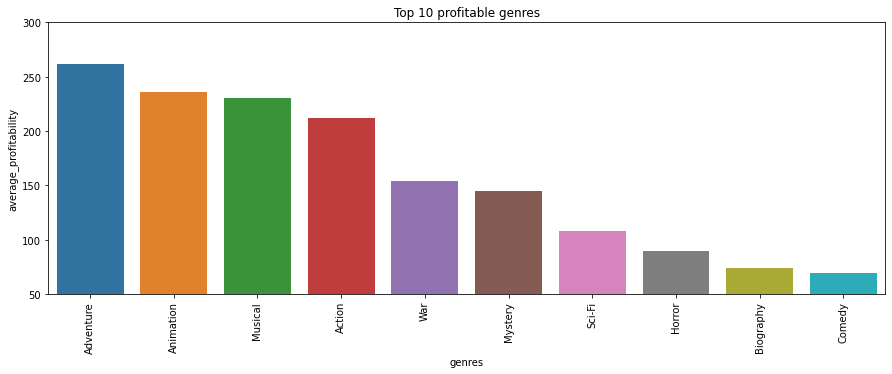

In [30]:
# using a barplot to represent the profitability of movies by genres


data2 = pd.read_sql(top_genres,conn) #load data

plt.figure(figsize=(15, 5)) #set figure size

plt.ylim(50, 300) #set y axis to start from 50 million$

ax = sns.barplot(x='genres', y='average_profitability', data=data2) #set values

ax.set_title("Top 10 profitable genres") #title

plt.xticks(rotation = 90) # rotation of the genre names for easier readability
plt.show()

#### Popularity of movie based on genre

In [31]:
# query that is going to show us the top ten most popular genres

top_10_popular_genres = """SELECT i.genres, AVG(t.popularity) AS average_popularity
                        FROM tmdb_ratings AS t
                        JOIN film_info AS i ON i.primary_title = t.original_title
                        GROUP BY i.genres
                        ORDER BY average_popularity DESC
                        LIMIT 10"""
pd.read_sql(top_10_popular_genres, conn)

,genres,average_popularity
0,Action,7.288281
1,Adventure,6.256002
2,Crime,4.115594
3,Biography,3.887870
4,Comedy,3.616680
5,Fantasy,3.562889
6,Mystery,3.501395
7,Drama,3.467522
8,Animation,3.405418
9,Romance,3.282500


**With an average popularity rating of 7.29, the action genre was the most popular, and the romance genre ranked tenth with an average popularity rating of 3.29. In this case, movies produced within the above genres are more likely to capture the audience's attention**







#### Visual representation of the topten most popular genres

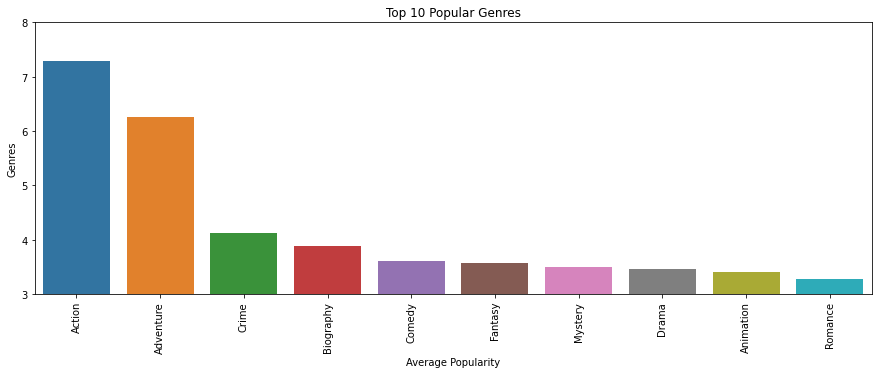

In [32]:
data3 = pd.read_sql(top_10_popular_genres, conn) #load data

plt.figure(figsize=(15, 5)) #set figure size

plt.ylim(3.0, 8.0) #set y axis t start from a rating of 3.0

sns.barplot(x='genres', y='average_popularity', data=data3) # set x and y values

#lables
plt.xlabel('Average Popularity')
plt.ylabel('Genres')

plt.title('Top 10 Popular Genres') #title names

plt.xticks(rotation=90) #set genre names to 90 degree rotation for readability
plt.show()

### Popularity and profitability of movies based on genre

#### Creating a data base with similar genres from profitability and popularity so that we can figure out which movies were both one of the most  profitable and most popular

In [33]:
#creating the profitability data frame

average_profitability = [280.058754, 275.816712, 235.053356, 225.879422, 177.784505, 139.226970, 76.175548, 73.992899, 72.444796, 55.037568]
genres = ['Adventure', 'Animation', 'Sci-Fi', 'Action', 'Mystery', 'Romance', 'Biography', 'Comedy', 'Horror', 'Crime']

data = {
    'average_profitability': [280.058754, 275.816712, 235.053356, 225.879422, 177.784505,
                               139.226970, 76.175548, 73.992899, 72.444796, 55.037568],
    'genres': ['Adventure', 'Animation', 'Sci-Fi', 'Action', 'Mystery', 'Romance',
               'Biography', 'Comedy', 'Horror', 'Crime']
}

genre_profitability = pd.DataFrame(data)

In [34]:
#creating the popularity dataframe

genres = ['Action', 'Adventure', 'Crime', 'Biography', 'Comedy', 'Fantasy', 'Mystery', 'Drama', 'Animation', 'Romance']
average_popularity= [7.288281, 6.256002, 4.115594, 3.887870, 3.616680, 3.562889, 3.501395, 3.467522, 3.405418, 3.282500]

data1 = {'genres': ['Action', 'Adventure', 'Crime', 'Biography', 'Comedy', 'Fantasy', 'Mystery', 'Drama', 'Animation', 'Romance'],
    'average_popularity': [7.288281, 6.256002, 4.115594, 3.887870, 3.616680, 3.562889, 3.501395, 3.467522, 3.405418, 3.282500]}

genre_popularity = pd.DataFrame(data1)

In [35]:
#merging the databases on the genre column using an inner join so as to get genres that are both popular and profitable.

genre_popularity_profitability= pd.merge(genre_profitability, genre_popularity, on='genres', how='inner')
genre_popularity_profitability

,average_profitability,genres,average_popularity
0,280.058754,Adventure,6.256002
1,275.816712,Animation,3.405418
2,225.879422,Action,7.288281
3,177.784505,Mystery,3.501395
4,139.226970,Romance,3.282500
5,76.175548,Biography,3.887870
6,73.992899,Comedy,3.616680
7,55.037568,Crime,4.115594


***From our results the above genres were both one of the most profitable and the most popular genres in the box office***






#### Visual representation of the most profitable and most popular movie genres

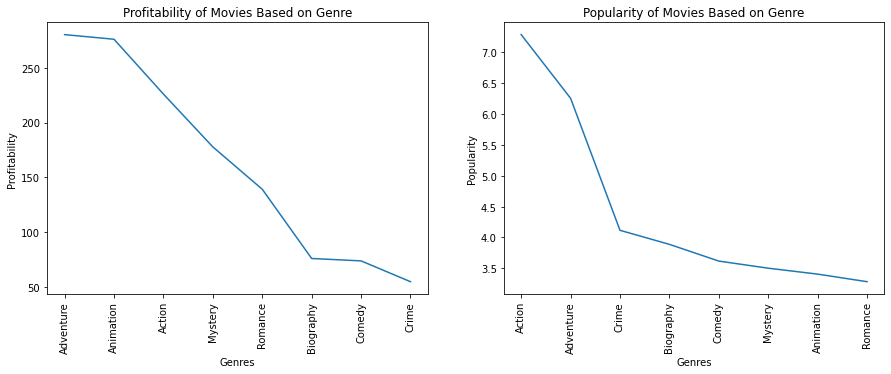

In [36]:
fig, (gx1, gx2) = plt.subplots(1, 2, figsize=(15, 5)) # Create subplots with 1 row and 2 columns

# Creating the profitability graph

y1 = [280.058754, 275.816712, 225.879422, 177.784505, 139.226970, 76.175548, 73.992899, 55.037568]
x1 = ['Adventure', 'Animation', 'Action', 'Mystery', 'Romance', 'Biography', 'Comedy', 'Crime']


gx1.plot(x1, y1) #plotting the graph


gx1.set_xlabel('Genres') # labeling the x and y axis 
gx1.set_ylabel('Profitability')


gx1.set_title('Profitability of Movies Based on Genre') #giving the plot a title


gx1.tick_params(axis='x', rotation=90) # rotating the genre names on the x axis for readability


# creating the popularity graph
y2 = [7.288281, 6.256002, 4.115594, 3.887870, 3.616680, 3.501395, 3.405418, 3.282500]  
x2 = ['Action', 'Adventure', 'Crime', 'Biography', 'Comedy', 'Mystery', 'Animation', 'Romance']


gx2.plot(x2, y2) # plotting the graph


gx2.set_xlabel('Genres') #labeling the x and y axis  
gx2.set_ylabel('Popularity')


gx2.set_title('Popularity of Movies Based on Genre') #giving the plot a title

gx2.tick_params(axis='x', rotation=90) # rotating the genre names on the x axis for readability
plt.show()

## ANALYSIS BASED ON RELEASE MONTH

#### Popularity of movies based on release month

In [37]:
# query to get the top ten most profitable months
top_six_popular_months = """SELECT CASE 
                                  WHEN strftime('%m', t.release_date) = '01' THEN 'January'
                                  WHEN strftime('%m', t.release_date) = '02' THEN 'February'
                                  WHEN strftime('%m', t.release_date) = '03' THEN 'March'
                                  WHEN strftime('%m', t.release_date) = '04' THEN 'April'
                                  WHEN strftime('%m', t.release_date) = '05' THEN 'May'
                                  WHEN strftime('%m', t.release_date) = '06' THEN 'June'
                                  WHEN strftime('%m', t.release_date) = '07' THEN 'July'
                                  WHEN strftime('%m', t.release_date) = '08' THEN 'August'
                                  WHEN strftime('%m', t.release_date) = '09' THEN 'September'
                                  WHEN strftime('%m', t.release_date) = '10' THEN 'October'
                                  WHEN strftime('%m', t.release_date) = '11' THEN 'November'
                                  WHEN strftime('%m', t.release_date) = '12' THEN 'December'
                             END AS month,
                             AVG(t.popularity) AS average_popularity
                             FROM tmdb_ratings AS t
                             GROUP BY month
                             ORDER BY average_popularity DESC
                             LIMIT 6"""

pd.read_sql(top_six_popular_months, conn)


,month,average_popularity
0,December,3.597107
1,July,3.586554
2,August,3.561893
3,February,3.239077
4,November,3.151852
5,September,3.144567


**Based on our observations, December releases were the most popular, with an average popularity of 3.60. Movies released in September were the sixth most popular at the box office, with an average popularity of 3.14. As a result, in order for our films to capture the attention of audiences, we should release them during the months mentioned above.**

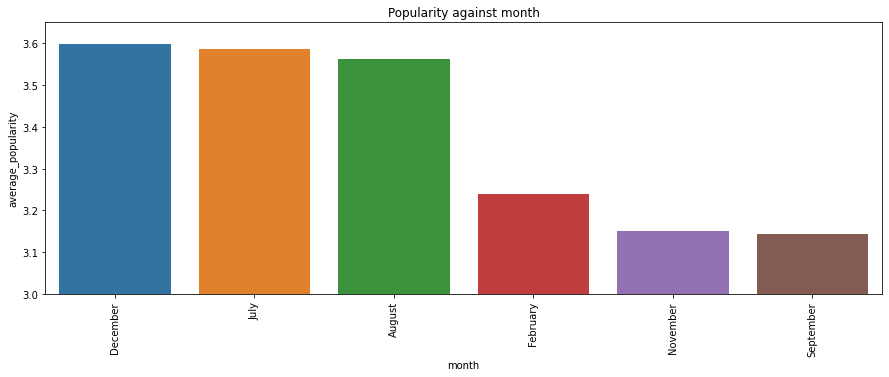

In [38]:
data4 = pd.read_sql(top_six_popular_months,conn) # name variable

plt.figure(figsize=(15, 5)) #set figure size

plt.ylim(3.0,3.65) #set y axis to start from 3.0

ax = sns.barplot(x='month', y='average_popularity', data=data4, ) #set points

ax.set_title("Popularity against month") # set title 

plt.xticks(rotation = 90) # set rotation of x values to 90 for easy readabilty

plt.show()

#### Profitability of movies based on months

In [39]:
top_six_profitable_months = """SELECT CASE 
                                  WHEN strftime('%m', t.release_date) = '01' THEN 'January'
                                  WHEN strftime('%m', t.release_date) = '02' THEN 'February'
                                  WHEN strftime('%m', t.release_date) = '03' THEN 'March'
                                  WHEN strftime('%m', t.release_date) = '04' THEN 'April'
                                  WHEN strftime('%m', t.release_date) = '05' THEN 'May'
                                  WHEN strftime('%m', t.release_date) = '06' THEN 'June'
                                  WHEN strftime('%m', t.release_date) = '07' THEN 'July'
                                  WHEN strftime('%m', t.release_date) = '08' THEN 'August'
                                  WHEN strftime('%m', t.release_date) = '09' THEN 'September'
                                  WHEN strftime('%m', t.release_date) = '10' THEN 'October'
                                  WHEN strftime('%m', t.release_date) = '11' THEN 'November'
                                  WHEN strftime('%m', t.release_date) = '12' THEN 'December'
                             END AS month,
                            
                             AVG(b.profitability) AS average_profitability
                             FROM tmdb_ratings AS t
                             JOIN film_budgets AS b ON t.original_title = b.movie
                             GROUP BY month
                             ORDER BY average_profitability DESC
                             LIMIT 6
                             """

pd.read_sql(top_six_profitable_months, conn)


,month,average_profitability
0,May,207.358399
1,July,206.896757
2,June,205.066504
3,November,177.507728
4,December,163.321876
5,February,108.883688


**From our observation May was the most profitable month in the box office with an average profit of 207.36 million dollars. February was the sixth most profitable month with an average profit of 108.88 million dollars** 




***Visual representation of the top 6 most profitable months***

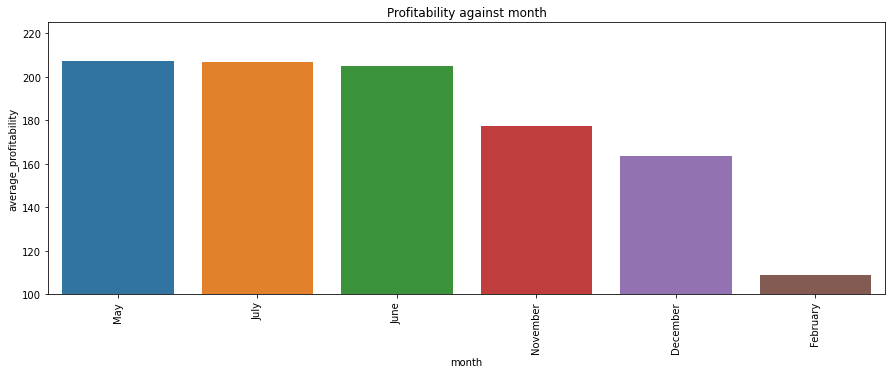

In [40]:
#name variable
data5 = pd.read_sql(top_six_profitable_months,conn)


plt.figure(figsize=(15, 5)) # set figure size
plt.ylim(100,225) #set y axis to start from 100 million$


ax = sns.barplot(x='month', y='average_profitability', data=data5, ) # set points

ax.set_title("Profitability against month") # set movie title

#set rotation of x values for better readability
plt.xticks(rotation = 90)

plt.show()

### Popularity and profitability of movies based on release months

We are going to merge data from the popularity data frame and the profitability data frame so that we can get relese months that were both profitable and popular

In [41]:
# create a popularity data frame

months = ['December', 'July', 'August', 'February', 'November', 'September']
average_popularity = [3.597107, 3.586554, 3.561893, 3.239077, 3.151852, 3.144567]

data2 = {'months':['December', 'July', 'August', 'February', 'November', 'September'],
'average_popularity':[3.597107, 3.586554, 3.561893, 3.239077, 3.151852, 3.144567]}

popular_months = pd.DataFrame(data2)

#creating a profitability data frame

months = ['May', 'July', 'June', 'November', 'December', 'February']
average_profitability = [207.358399, 206.896757, 205.066504, 177.507728, 163.321876, 108.883688]

data3= {'months':['May', 'July', 'June', 'November', 'December', 'February'],
'average_profitability':[207.358399, 206.896757, 205.066504, 177.507728, 163.321876, 108.883688]}

profitable_months = pd.DataFrame(data3)

In [42]:
# merging the data frames on the months column using an inner join so as to get months that are both profitable and popular.

most_popular_profitable_months= pd.merge(profitable_months,popular_months, on='months',how = 'inner')
most_popular_profitable_months

,months,average_profitability,average_popularity
0,July,206.896757,3.586554
1,November,177.507728,3.151852
2,December,163.321876,3.597107
3,February,108.883688,3.239077


***From our observation the following months were the most profitable and most popular release months in the box office***



***Visual presentation of the most popular_profitable release months***

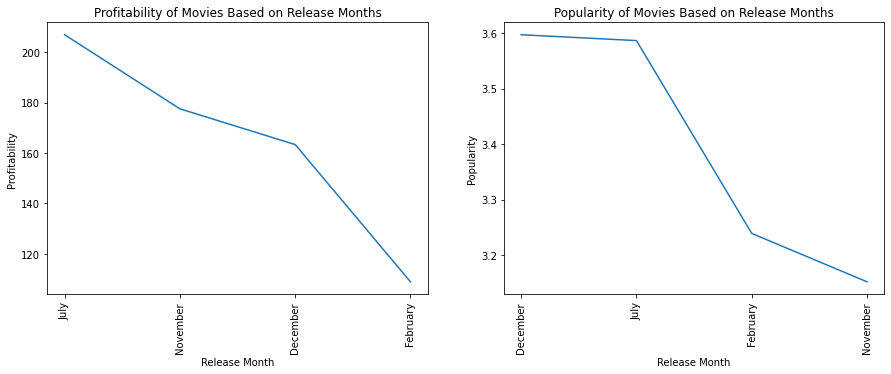

In [43]:
fig, (mx1, mx2) = plt.subplots(1, 2, figsize=(15, 5)) # Create subplots with 1 row and 2 columns

# Creating the profitability graph

x1 = ['July','November', 'December', 'February']
y1= [206.896757,177.507728, 163.321876, 108.883688]


mx1.plot(x1, y1) #plotting the graph


mx1.set_xlabel('Release Month') # labeling the x and y axis 
mx1.set_ylabel('Profitability')


mx1.set_title('Profitability of Movies Based on Release Months') #giving the plot a title


mx1.tick_params(axis='x', rotation=90) # rotating the months on the x axis for readability


# creating the popularity graph
x2 = ['December', 'July', 'February', 'November']
y2 = [3.597107, 3.586554, 3.239077, 3.151852]

mx2.plot(x2, y2) # plotting the graph


mx2.set_xlabel('Release Month') #labeling the x and y axis  
mx2.set_ylabel('Popularity')


mx2.set_title('Popularity of Movies Based on Release Months') #giving the plot a title

mx2.tick_params(axis='x', rotation=90) # rotating the months on the x axis for readability
plt.show()

***July, November, December and February were the most profitable and popular release months in the box office***

## BUSINESS SOLUTIONS

#### MOVIE GENRES

Following extensive research and analysis of box office movie patterns, certain movie genres consistently stand out as the most popular and profitable options. This genres include Adventure, animation, action, mystery, romance, biography, and comedy. To maximize return on investment and ensure commercial success in the industry, the company should strategically focus on producing films within the top ten most profitable genres and popular genres.

**INSIGHT**

    1. Identifying Profitable Genres: According to the research findings, the genres of adventure, animation, action,    
    mystery,romance, biography, and comedy have consistently demonstrated high popularity and profitability at the box
    office. By focusing film production efforts on these genres, the company can increase chances of financial success
    and a significant return on investment.
    
    2.Meeting Audience Preferences: These genres have a strong audience engagment, indicating a high demand for 
    these types of films. The company can strengthen its connection with viewers and improve its overall market position 
    by catering to their preferences.
    
    3.Risk Mitigation: Investing in film production entails inherent risks, such as uncertainties in audience reception and revenue generation. This risks can be reduced by focusing on genres with a proven track record of success.
    
    
**PROPOSAL**

I propose the following strategies to capitalize on the research findings and ensure a profitable venture in the film industry:


    1. Genre-Focused Content Creation: Dedicate resources and efforts to creating a significant portion of film projects in the top ten most profitable and popular genres putting emphasis on the genres that appear in both. This will allow 
    the company to focus on areas with a higher likelihood of box office success.
    
    2.Market Research and Trend Analysis: Continue to conduct extensive market research and trend analysis to stay informed of shifting audience preferences. This will allow the company to adjust the production schedule 
    accordingly and capitalize on emerging trends.This will also enable the company to make data driven descisions.
    

#### RELEASE MONTHS

Based on the analysis of movie data, it has been observed that certain release months have both high profitability and popularity. Specifically, the months of December, July, February, and November.

**INSIGHT**

    1.The month of December is generally known as a peak movie-going season due to the holidays and festivity.  As a result, movie releases during December often attract larger audiences, leading to increased box office revenues hence
    profitability.
    
    2.November, being the month preceding the holiday season, also has an increase in audience enthusiasm for new film 
    releases, making it an ideal time for movie releases.
    
    3.From our analysis, July and February are also great months for movie releases.
    
**PROPOSAL** 

I propose the following strategies to ensure a successful venture in the film industry.

    1.Focus on High-Performance Months: Set aside a significant portion of film releases for the top ten most profitable
    and popular release months, putting an emphasis on the months that appear in both.
    
    2.Plan the film production schedules to coincide with the high-performing months.
    
    3.Use data analytics and market research to fine-tune marketing strategies for film releases during these peak
    months.
    
By focusing on the identified release months, the company will be able to capitalize on peak audience interest and maximize profitability.